In [1]:
import numpy as np
import pandas as pd

from IPython.core.pylabtools import figsize
from IPython.display  import display

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set(font_scale=1.5)
plt.rcParams['font.family'] = 'IPAGothic'

In [3]:
READ_LOCAL_PICKLE = 1
if READ_LOCAL_PICKLE:
    raw_df = pd.read_pickle('raw_df.pkl')
else:
    raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
    raw_df.to_pickle('raw_df.pkl')

In [4]:
display(raw_df.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [6]:
# Cleaning
cleaned_df = raw_df.copy()

# `Time` カラムは不要
cleaned_df.pop('Time')

# `Amount` カラムは数値のレンジが広すぎるので対数化
eps = 0.001
cleaned_df['LogAmount'] = np.log(cleaned_df.pop('Amount') + eps)

In [7]:
from sklearn.model_selection import train_test_split

# split train and test.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2, random_state=123)

# split label and feature
train_labels = np.array(train_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
test_features = np.array(test_df)

In [8]:
np.bincount(test_labels)

array([56847,   115])

## 普通に全データセットからランダムにミニバッチを作成して学習させる

In [9]:
# define model

import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(29, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


simple_net = SimpleNet()

In [10]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label
        self.data_num = feature.shape[0]

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        out_feature = self.feature[idx]
        out_label = self.label[idx]
        return out_feature, out_label
    
BATCH_SIZE = 1000
trainset = MyDataset(feature=train_features, label=train_labels)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = MyDataset(feature=test_features, label=test_labels)
testloader = DataLoader(testset, shuffle=False)

In [11]:
import torch.optim as optim

criterion = nn.BCELoss() # BCELoss: Binary Crossentropy
optimizer = optim.Adam(simple_net.parameters(), lr=1e-3)

In [12]:
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = simple_net(inputs.float())
        loss = criterion(outputs, labels.view(-1, 1).float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.376
[1,   200] loss: 0.022
[2,   100] loss: 0.007
[2,   200] loss: 0.006
Finished Training


In [13]:
from sklearn.metrics import classification_report

pred = []
Y = []
for x, y in testloader:
    with torch.no_grad():
        output = simple_net(x.float())
    pred += [1 if output > 0.5 else 0]
    Y += [int(l) for l in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56847
           1       0.00      0.00      0.00       115

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



/Users/a_oka/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from sklearn.metrics import confusion_matrix


def print_cmx(y_true, y_pred, labels=None):
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (6,4.5))
    plt.rcParams['font.size'] = 15
    ax = sns.heatmap(df_cmx, cmap='Reds', annot=True, fmt="d", xticklabels=True, yticklabels=True)
    ax.xaxis.set_ticks_position("top") 
    if labels is not None:
        ax.set_yticklabels(reversed(labels), rotation=0)
    ax.set_xlabel("predicted label")
    ax.set_ylabel("real label")

    plt.show()

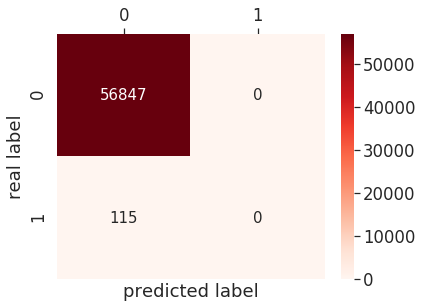

In [17]:
print_cmx(Y, pred)

全部ラベル0（多数派）で予測されている

## 各ラベルのサイズが均一なミニバッチで学習させる

In [18]:
class BinaryBalancedSampler:
    def __init__(self, features, labels, n_samples):
        self.features = features
        self.labels = labels 
        
        label_counts = np.bincount(labels)
        if label_counts.shape[0] != 2:
            raise ValueError(f'Expected 2 class size but got {label_counts.shape[0]} class')
        if label_counts.min() < n_samples:
            raise ValueError('`n_samples` must be less than minor label data size')
        major_label = label_counts.argmax()
        minor_label = label_counts.argmin()
        
        self.major_indices = np.where(labels == major_label)[0]
        self.minor_indices = np.where(labels == minor_label)[0]
        
        np.random.shuffle(self.major_indices)
        np.random.shuffle(self.minor_indices)
        
        self.used_indices = 0
        self.count = 0
        self.n_samples = n_samples
        self.batch_size = self.n_samples * 2

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.major_indices):
            indices = self.major_indices[self.used_indices:self.used_indices + self.n_samples].tolist()\
                      + np.random.choice(self.minor_indices, self.n_samples, replace=False).tolist()
            yield torch.tensor(self.features[indices]), torch.tensor(self.labels[indices])
            
            self.used_indices += self.n_samples
            self.count += self.n_samples * 2

    def __len__(self):
        return len(self.major_indicies) // self.batch_size

In [19]:
test = BinaryBalancedSampler(features=train_features, labels=train_labels, n_samples=50)
for i in test:
    tmp_input, tmp_label = i
    print(tmp_input.shape)
    print(tmp_label.shape)
    print(np.bincount(tmp_label))
    break

torch.Size([100, 29])
torch.Size([100])
[50 50]


In [20]:
import torch.optim as optim

balanced_net = SimpleNet()
balanced_loader = BinaryBalancedSampler(features=train_features, labels=train_labels, n_samples=50)

criterion = nn.BCELoss() # BCELoss: Binary Crossentropy
optimizer = optim.Adam(balanced_net.parameters(), lr=1e-3)

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(balanced_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = balanced_net(inputs.float())
        loss = criterion(outputs, labels.view(-1, 1).float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.115
[1,  2000] loss: 0.027
[2,  1000] loss: 0.015
[2,  2000] loss: 0.012
Finished Training


In [21]:
from sklearn.metrics import classification_report

pred = []
Y = []
for x, y in testloader:
    with torch.no_grad():
        output = balanced_net(x.float())
    pred += [1 if output > 0.5 else 0]
    Y += [int(l) for l in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56847
           1       0.39      0.91      0.55       115

    accuracy                           1.00     56962
   macro avg       0.70      0.96      0.77     56962
weighted avg       1.00      1.00      1.00     56962



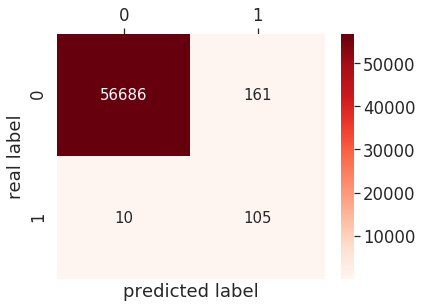

In [22]:
print_cmx(Y, pred)

ラベル0の誤検知を抑えつつラベル1を9割くらい拾えた